# Project: Traffic signs classifier

The task of this project was to create a traffic sign classifier using the convolutional neural network "Lenet" and a provided set of training images.

## 1. Loading the data

At first, the provided files are loaded and the images and corresponding sign classes get extracted. Some basic metrics of the data sets are displayed.

In [1]:
import os
import pickle
import collections
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def load_data():
    data_folder = 'Resources/TrafficSigns'
    training_file = os.path.join(data_folder, 'train.p')
    validation_file = os.path.join(data_folder, 'valid.p')
    testing_file = os.path.join(data_folder, 'test.p')
    
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
        
    return train, valid, test


train, valid, test = load_data()
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
#classes = Counter(y_train)
classes = collections.OrderedDict(sorted(collections.Counter(y_train).items()))

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(classes)

print()
print('DATASETS EXPLORATION')
print('-------------------------------------------')
print('Number of training examples:   ', n_train)
print('Number of validation examples: ', n_valid)
print('Number of testing examples:    ', n_test)
print('Image data shape:              ', image_shape)
print('Number of classes:             ', n_classes)
print('-------------------------------------------')


DATASETS EXPLORATION
-------------------------------------------
Number of training examples:    34799
Number of validation examples:  4410
Number of testing examples:     12630
Image data shape:               (32, 32, 3)
Number of classes:              43
-------------------------------------------


## 2. Exploring the training data set

The training data set is now being explored a bit more in depth. The occurence of each class within the data is displayed in the bar chart below. One can easily see that the images are not distributed evenly over the classes. As we will see later, for classes like "Slippery Road", which has much less examples than other classes, we can still get a pretty good predicition. This is the reason why I did not try to generate fake data in a way that fills the gaps and evens the distribution. 

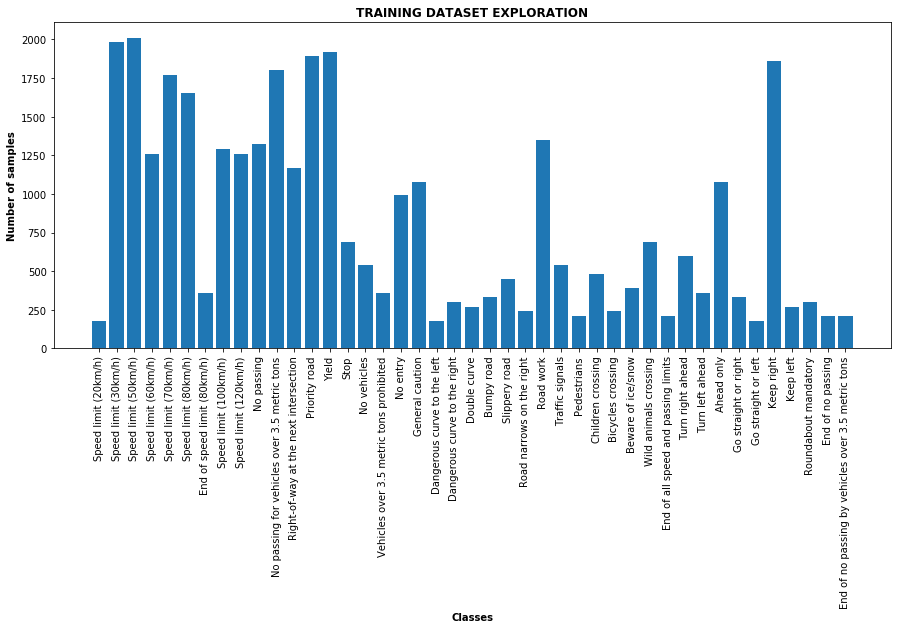

In [2]:
import csv


def create_sign_dict():
    sign_dict = {}
    with open('Resources/TrafficSigns/trafficsignnames.csv') as file:
        reader = csv.reader(file, delimiter=',')
        # Skip the header
        next(reader)
        for row in reader:
            sign_dict[int(row[0])] = row[1]
    return sign_dict


sign_dict = create_sign_dict()
labels = sign_dict.values()
values = classes.values()
indices = np.arange(len(labels))

print()
fig = plt.figure(num=1, figsize=(15, 6))
plot = fig.add_subplot(1, 1, 1)
plt.bar(indices, values)
plt.xticks(indices, labels, rotation=90)
plot.set_title("TRAINING DATASET EXPLORATION", fontweight='bold')
plot.set_xlabel("Classes", fontweight='bold')
plot.set_ylabel("Number of samples", fontweight='bold')
plt.show()

## 3. Image processing and fake data generation

Processing the images before using them for training is an important step. This way, similar conditions can be created for all images. The basic image processing steps contain:

1. Conversion to grayscale
2. Histogram equalization
3. Normalization to [-1, 1]

All three steps are combined together within an OpenCL kernel that will run on the graphics card. Furthermore, the actual training set is doubled by generating an altered image for each already existing image. For this, one of three operations is chosen randomly:

- Rotation
- Noise
- Skew

This helps the network to correctly recognize signs that are seen from different angles or signs that are dirty. For each operation, the magnitude is also chosen randomly. The results of image processing and fake data generation can be seen below. For each operation, one example image is shown.


Chosen OpenCL device: GeForce GTX 1060 6GB
Fake data generated



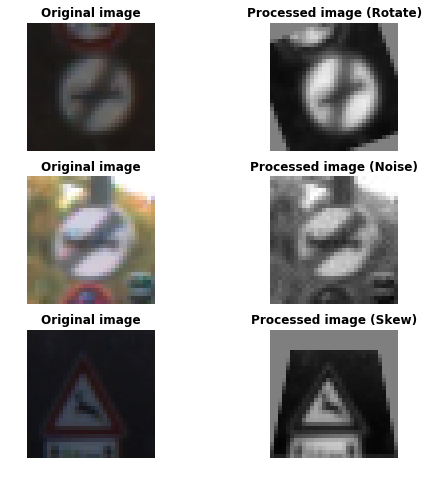

In [3]:
import cv2
import random
import opencl4py as cl


IMG_WIDTH = 32
IMG_HEIGHT = 32


cl_queue = None
cl_context = None
cl_image_processing_kernel = None


class Operations:
    ROTATE = 0
    NOISE = 1
    SKEW = 2
    NUM_OPERATIONS = 3
    names = ['Rotate', 'Noise', 'Skew']
    

def load_kernels():
    global cl_image_processing_kernel, cl_queue, cl_context

    platforms = cl.Platforms()
    cuda_platform = None

    for p in platforms:
        # It is hard to determine the device with the most power.
        # As my machines only have Nvidia graphics cards, just filter for the Nvidia CUDA platform
        if 'cuda' in p.name.lower():
            cuda_platform = p
            break

    if cuda_platform is None:
        print('No suitable device found. Exiting.')
        exit(0)

    device = cuda_platform.devices[0]
    print('Chosen OpenCL device: {0}'.format(cuda_platform.devices[0].name))
    
    cl_context = cuda_platform.create_context([device])

    cl_queue = cl_context.create_queue(device)
    program = cl_context.create_program(
        """
        __kernel void imageProcessing(__global const uchar* rgbImage, __global const float* parameters, __global float* grayImage) {{
            size_t imgIdx = get_global_id(0);
            size_t rgbIdx = {0} * imgIdx; 
            size_t grayIdx = {1} * imgIdx;
            size_t paramIdx = 2 * imgIdx;
            for (int y = 0; y < {2}; y++) {{
                for (int x = 0; x < {3}; x++) {{
                    float gray = 0.21 * rgbImage[rgbIdx] + 0.72 * rgbImage[rgbIdx + 1] + 0.07 * rgbImage[rgbIdx + 2];
                    float grayEqualized = (gray - parameters[paramIdx]) * 255.0 / parameters[paramIdx + 1];
                    grayImage[grayIdx] = (grayEqualized - 128.0) / 128.0;
                    grayIdx++;
                    rgbIdx += 3;
                }}
            }}
        }}
        """.format(3*IMG_WIDTH*IMG_HEIGHT, IMG_WIDTH*IMG_HEIGHT, IMG_WIDTH, IMG_HEIGHT))

    cl_image_processing_kernel = program.get_kernel('imageProcessing')
    

def image_processing(images):
    n_images = len(images)
    param_array = np.empty((n_images, 2), dtype=np.float32)

    for idx, img in enumerate(images):
        min = np.ndarray.min(img)
        max = np.ndarray.max(img)
        param_array[idx][0] = min
        param_array[idx][1] = max - min

    image_array = np.ndarray.flatten(images)
    output = np.empty(int(images.size / 3), dtype=np.float32)

    input_buffer = cl_context.create_buffer(cl.CL_MEM_READ_ONLY | cl.CL_MEM_COPY_HOST_PTR, image_array)
    param_buffer = cl_context.create_buffer(cl.CL_MEM_READ_ONLY | cl.CL_MEM_COPY_HOST_PTR, param_array)
    output_buffer = cl_context.create_buffer(cl.CL_MEM_WRITE_ONLY | cl.CL_MEM_ALLOC_HOST_PTR, size=output.nbytes)

    cl_image_processing_kernel.set_arg(0, input_buffer)
    cl_image_processing_kernel.set_arg(1, param_buffer)
    cl_image_processing_kernel.set_arg(2, output_buffer)
    cl_queue.execute_kernel(cl_image_processing_kernel, [n_images], None)
    cl_queue.read_buffer(output_buffer, output)

    output_images = output.reshape((n_images, IMG_WIDTH, IMG_HEIGHT, 1))
    return output_images


def rotate_img(img, angle):
    M = cv2.getRotationMatrix2D((IMG_WIDTH / 2, IMG_HEIGHT / 2), angle, 1)
    rotated = cv2.warpAffine(img, M, (IMG_WIDTH, IMG_HEIGHT)).reshape((IMG_WIDTH, IMG_HEIGHT, 1))
    return rotated


def skew_img(img, shift):
    pts1 = np.float32([[0, 0], [IMG_WIDTH, 0], [0, IMG_HEIGHT], [IMG_WIDTH, IMG_HEIGHT]])
    pts2 = np.float32([[shift, shift], [IMG_WIDTH - shift, shift], [0, IMG_HEIGHT], [IMG_WIDTH, IMG_HEIGHT]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    skewed = cv2.warpPerspective(img, M, (IMG_WIDTH, IMG_HEIGHT)).reshape((IMG_WIDTH, IMG_HEIGHT, 1))
    return skewed


def generate_fake_data(images, img_example_idx):
    new_images = np.empty(images.shape)

    for i in range(len(new_images)):
        new_image = None
        is_example_img = True
        
        # For example images
        if i == img_example_idx[0]:
            operation = 0
        elif i == img_example_idx[1]:
            operation = 1
        elif i == img_example_idx[2]:
            operation = 2
        else:
            is_example_img = False
            operation = random.randrange(0, Operations.NUM_OPERATIONS)
            
        if operation == Operations.ROTATE:
            angle = 20 if is_example_img else random.randrange(-20, 20)
            new_image = rotate_img(images[i], angle)

        elif operation == Operations.NOISE:
            noise = np.random.randn(IMG_WIDTH, IMG_HEIGHT, 1).astype(np.float32) / 30.0
            new_image = images[i] + noise

        elif operation == Operations.SKEW:
            shift = 5 if is_example_img else random.randrange(-5, 5)
            new_image = skew_img(images[i], shift)

        else:
            print('Invalid operation')
            exit(0)

        new_images[i] = new_image
        
    return new_images


def copy_images(images, indices):
    images_copy = np.empty((len(indices), IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
    for i, idx in enumerate(indices):
        images_copy[i] = np.copy(images[idx])
    return images_copy


print()
load_kernels()

img_example_idx = [0, 100, 250]
X_train_orig = copy_images(X_train, img_example_idx)

X_train = image_processing(X_train)
X_valid = image_processing(X_valid)
X_test = image_processing(X_test)

new_images = generate_fake_data(X_train, img_example_idx)
X_train = np.concatenate((X_train, new_images))
y_train = np.concatenate((y_train, y_train))
print('Fake data generated')

print()
n_examples = len(img_example_idx)
fig = plt.figure(figsize=(8, 8))

for i, img_idx in enumerate(img_example_idx):
    orig = fig.add_subplot(n_examples, 2, 2*i+1)
    orig.set_title("Original image", fontweight='bold')
    plt.imshow(X_train_orig[i])
    plt.axis('off')

    processed = fig.add_subplot(n_examples, 2, 2*i+2)
    processed.set_title("Processed image ({0})".format(Operations.names[i]), fontweight='bold')
    plt.imshow(X_train[n_train + img_idx].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')

plt.show()

# 4. Tensorflow model

The model is mostly the same as the already provided Lenet model. At first, I was not able to get above a validation accuracy of 93%. After revisiting the lectures again, I suspected that a dropout layer is necessary, as this is proven to increase a model's performance drastically. Some research on the internet confirmed this idea. Thus, I added a dropout layer after each activation layer. For convolutional layers, I chose a keeping rate of 0.75, for fully connected layers 0.5. This way, I reached an accuracy of around 95%-96%. Adding the fake data described in chapter 3, I ended up with an accuracy of 97%. The training and accuracy operations have been taken from the lectures and have not been modified.

The model consists of the following layers:

| Layer             | Description                      |
| ----------------- | -------------------------------- |
| Input             | Images in format 32x32x1         |
| Convolution 5x5   | Input: 32x32x1, Output: 28x28x6  |
| Activation        | RELU Activation                  |
| Dropout           | Keep Probability: 0.75           |
| Max Pooling       | Input: 28x28x6, Output: 14x14x6  |
| Convolution 5x5   | Input: 14x14x6, Output: 10x10x16 |
| Activation        | RELU Activation                  |
| Dropout           | Keep Probability: 0.75           |
| Max Pooling       | Input: 10x10x16, Output: 5x5x16  |
| Flatten           | Input: 5x5x16, Output: 400       |
| Fully connected   | Input: 400, Output: 120          |
| Activation        | RELU Activation                  |
| Dropout           | Keep Probability: 0.5            |
| Fully connected   | Input: 120, Output: 84           |
| Activation        | RELU Activation                  |
| Dropout           | Keep Probability: 0.5            |
| Fully connected   | Input: 84, Output: 43            |
| Softmax           | Probability for each class       |

In [4]:
import tensorflow as tf


LEARNING_RATE = 0.001


def lenet(x, keep_prob_conv, keep_prob_fc, img_channels):
    mu = 0
    sigma = 0.1

    # Layer 1: Convolution. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, img_channels, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob_conv)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolution. Input = 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob_conv)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = tf.contrib.layers.flatten(conv2)

    # Layer 3: Fully connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob_fc)

    # Layer 4: Fully connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob_fc)

    # Layer 5: Fully connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    probs = tf.nn.softmax(logits)

    return logits, probs


y = tf.placeholder(tf.int32)
x = tf.placeholder(tf.float32, (None, IMG_WIDTH, IMG_HEIGHT, 1))

keep_prob_conv = tf.placeholder(tf.float32)
keep_prob_fc = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

logits, probs = lenet(x, keep_prob_conv, keep_prob_fc, 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print()
print('Tensorflow model generated')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.


Tensorflow model generated


# 5. Training, validating and testing the model

The model and the data will now be used to train the model. The data is shuffled for each iteration (epoch) and then divided into batches of size 128. As I know that the model will reach a maximum accuracy of 97%, the training loop does not have a fixed number of iterations. It will run until it reaches that defined minimum accuracy. Afterwards, the Tensorflow session is being saved to the hard drive. It is important to set the keeping probabilities to 1 for the accuracy operation.

In [5]:
import sklearn.utils


BATCH_SIZE = 128
KEEP_PROB_FC = 0.5
KEEP_PROB_CONV = 0.75
MIN_ACCEPTED_TRAIN_ACCURACY = 0.97


def evaluate(X_data, y_data):
    total_accuracy = 0
    num_examples = len(X_data)
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x = X_data[offset:end]
        batch_y = y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: 1.0, keep_prob_fc: 1.0})
        total_accuracy += accuracy * len(batch_x)

    return total_accuracy / num_examples


saver = tf.train.Saver()
session_path = 'Resources/TensorflowModel/Session.ckpt'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print()
    print('Training until minimum validation accuracy of {0}...'.format(MIN_ACCEPTED_TRAIN_ACCURACY))
    print()
    
    epoch = 1
    validation_accuracy = 0

    while validation_accuracy < MIN_ACCEPTED_TRAIN_ACCURACY:
        X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
        for offset in range(0, len(X_train), BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x = X_train[offset:end]
            batch_y = y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv: KEEP_PROB_CONV, keep_prob_fc: KEEP_PROB_FC})

        validation_accuracy = evaluate(X_valid, y_valid)
        test_accuracy = evaluate(X_test, y_test)
        
        print('EPOCH {0} ...'.format(epoch))
        print('Validation accuracy: {:.3f}'.format(validation_accuracy))
        print('Test accuracy:       {:.3f}'.format(test_accuracy))
        print()
        
        epoch += 1
        
    saver.save(sess, session_path)

print('Training finished')


Training until minimum validation accuracy of 0.97...

EPOCH 1 ...
Validation accuracy: 0.803
Test accuracy:       0.816

EPOCH 2 ...
Validation accuracy: 0.878
Test accuracy:       0.878

EPOCH 3 ...
Validation accuracy: 0.905
Test accuracy:       0.903

EPOCH 4 ...
Validation accuracy: 0.915
Test accuracy:       0.906

EPOCH 5 ...
Validation accuracy: 0.935
Test accuracy:       0.919

EPOCH 6 ...
Validation accuracy: 0.932
Test accuracy:       0.924

EPOCH 7 ...
Validation accuracy: 0.941
Test accuracy:       0.928

EPOCH 8 ...
Validation accuracy: 0.946
Test accuracy:       0.930

EPOCH 9 ...
Validation accuracy: 0.946
Test accuracy:       0.931

EPOCH 10 ...
Validation accuracy: 0.952
Test accuracy:       0.935

EPOCH 11 ...
Validation accuracy: 0.945
Test accuracy:       0.929

EPOCH 12 ...
Validation accuracy: 0.951
Test accuracy:       0.937

EPOCH 13 ...
Validation accuracy: 0.957
Test accuracy:       0.935

EPOCH 14 ...
Validation accuracy: 0.954
Test accuracy:       0.941

E

# 6. Loading new images

The trained model is now being loaded and tested against five images of German traffic signs that I found with Google.
The first row of images below shows the unchanged test images, the second row shows the processed ones (grayscale and histogram equalization). 

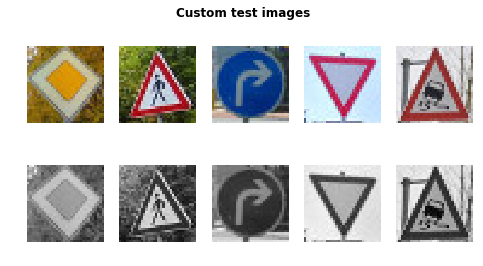

In [6]:
def load_image(file_name):
    img = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)
    return img


test_images_dict = {
    12: load_image('Resources/Images/Test01_cropped.jpg'),
    27: load_image('Resources/Images/Test02_cropped.jpg'),
    33: load_image('Resources/Images/Test03_cropped.jpg'),
    13: load_image('Resources/Images/Test04_cropped.jpg'),
    23: load_image('Resources/Images/Test05_cropped.jpg')
}

n_test_imgs = len(test_images_dict)

print()
fig = plt.figure(figsize=(8, 4))
plt.suptitle('Custom test images', fontweight='bold')

for idx, (sign_id, image) in enumerate(test_images_dict.items()):
    fig.add_subplot(2, n_test_imgs, idx+1)
    plt.imshow(image)
    plt.axis('off')
    
    test_images_dict[sign_id] = image_processing(np.ndarray.reshape(image, (1, IMG_WIDTH, IMG_HEIGHT, 3)))
    fig.add_subplot(2, n_test_imgs, n_test_imgs+idx+1)
    plt.imshow(test_images_dict[sign_id].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')

# 7. Test the new images

The Tensorflow session is being restored from the hard drive and the processed test images are fed into the model. Again, the keeping probabilities have to be set to 1. The retrieved softmax probabilities for each image are sorted in descending order. The five highest probabilities are being printed together with the corresponding name of the class. The sign with the highest probability is printed as the predicted sign. Below, the overall performance is shown, meaning the percentage of correctly detected images. At the very end, a bar chart is plotted that shows how safe the model is about its predictions for each test image.

As stated in the very beginning, signs like the slippery road can be detected with a fairly high accuracy, even if there are only a few samples in the training set. Concerning speed limit signs, the performance is clearly worse. I tried some of them before, but the model misclassified them almost every time, i.e. a 80 km/h would be predicted as 30 km/h. I understand that some of the numbers look pretty similar, especially if the sign is dirty or tilted in some way. Still I am a bit surprised, that the performance was so bad on those signs.

INFO:tensorflow:Restoring parameters from Resources/TensorflowModel/Session.ckpt




Test image:     "Priority road"
Predicted sign: "Priority road"
---------------------------------------------------------
Softmax probablilites:
  Priority road: 0.9999998807907104
  Keep right: 1.0848358300563632e-07
  Roundabout mandatory: 1.3199441539768486e-08
  Yield: 1.1802122612536436e-09
  End of all speed and passing limits: 9.078701679321455e-10
---------------------------------------------------------


Test image:     "Pedestrians"
Predicted sign: "Pedestrians"
---------------------------------------------------------
Softmax probablilites:
  Pedestrians: 0.7959978580474854
  Road narrows on the right: 0.13424243032932281
  General caution: 0.06698258221149445
  Traffic signals: 0.002565627684816718
  Right-of-way at the next intersection: 0.000151592685142532
---------------------------------------------------------


Test image:     "Turn right ahead"
Predicted sign: "Turn right ahead"
--

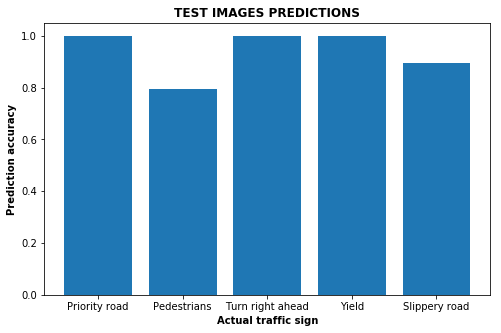

In [8]:
with tf.Session() as sess:
    saver.restore(sess, session_path)
    print()
    print()
    
    sign_names = []
    sign_probabilities = []
    correct_detected = 0
    
    for sign_id, img in test_images_dict.items():
        softmax_probs = sess.run(probs, feed_dict={x: img, y: [sign_id], keep_prob_conv: 1.0, keep_prob_fc: 1.0})[0]
        softmax_probs_idx = sorted(range(len(softmax_probs)), key=lambda k: softmax_probs[k], reverse=True)
        
        print()
        print()
        print('Test image:     "{0}"'.format(sign_dict[sign_id]))
        print('Predicted sign: "{0}"'.format(sign_dict[softmax_probs_idx[0]]))
        print('---------------------------------------------------------')
        print('Softmax probablilites:')
        for idx in softmax_probs_idx[0:5]:
            print('  {0}: {1}'.format(sign_dict[idx], softmax_probs[idx]))
        print('---------------------------------------------------------')
        
        detected_sign_id = softmax_probs_idx[0]
        sign_names.append(sign_dict[detected_sign_id])
        sign_probabilities.append(softmax_probs[detected_sign_id])
        correct_detected += 1 if detected_sign_id == sign_id else 0

correct_percentage = 100 * correct_detected / n_test_imgs
print()
print()
print('---------------------------------------------------------')
print('Performance: {:.0f}% of images have been detected correctly.'.format(correct_percentage))
print('---------------------------------------------------------')
print()

fig = plt.figure(num=1, figsize=(8, 5))
plot = fig.add_subplot(1, 1, 1)
plt.bar(sign_names, sign_probabilities)
plot.set_title("TEST IMAGES PREDICTIONS", fontweight='bold')
plot.set_xlabel("Actual traffic sign", fontweight='bold')
plot.set_ylabel("Prediction accuracy", fontweight='bold')
plt.show()